# Text analysis

This notebook provides a comprehensive analysis of the text data generated by the LLMs.

In [8]:
# Imports
import polars as pl

DATA_PATH = "../../data/results/all_experiments.parquet"

In [9]:
# Load one example
df = pl.read_parquet(DATA_PATH)

In [11]:
df = df.with_columns(
    (pl.col("observations") + " " + pl.col("insights") + pl.col("plans")).alias("text")
)

## LDA

In [12]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings

warnings.filterwarnings("ignore")


class FolkTheoremLDAAnalyzer:
    def __init__(self, df, n_topics=8, random_state=42):
        """
        Initialize LDA analyzer for Folk Theorem study

        Args:
            df: Polars DataFrame with the experiment data
            n_topics: Number of topics for LDA
            random_state: Random seed for reproducibility
        """
        self.df = df
        self.n_topics = n_topics
        self.random_state = random_state

        # Text preprocessing parameters
        self.vectorizer_params = {
            "max_features": 1000,
            "min_df": 2,
            "max_df": 0.95,
            "stop_words": "english",
            "ngram_range": (1, 2),
        }

        # LDA parameters
        self.lda_params = {
            "n_components": n_topics,
            "random_state": random_state,
            "max_iter": 100,
            "learning_method": "online",
            "learning_offset": 50.0,
        }

        self.results = {}

    def preprocess_text(self, texts):
        """Clean and preprocess text for LDA"""
        # Convert to pandas for easier text processing
        if isinstance(texts, pl.Series):
            texts = texts.to_pandas()

        # Basic cleaning
        processed_texts = []
        for text in texts:
            if pd.isna(text) or text == "":
                processed_texts.append("empty_text")
            else:
                # Convert to lowercase and basic cleaning
                clean_text = str(text).lower()
                # Remove common LLM artifacts
                clean_text = clean_text.replace("my observations and thoughts:", "")
                clean_text = clean_text.replace("new content for plans.txt:", "")
                clean_text = clean_text.replace("new content for insights.txt:", "")
                clean_text = clean_text.replace("my chosen price:", "")
                processed_texts.append(clean_text)

        return processed_texts

    def fit_lda_for_subset(self, texts, subset_name):
        """Fit LDA for a specific subset of texts"""
        if len(texts) < 5:  # Need minimum texts for meaningful topics
            return None, None, None

        processed_texts = self.preprocess_text(texts)

        # Vectorize texts
        vectorizer = CountVectorizer(**self.vectorizer_params)
        doc_term_matrix = vectorizer.fit_transform(processed_texts)

        # Fit LDA
        lda = LatentDirichletAllocation(**self.lda_params)
        lda.fit(doc_term_matrix)

        # Get topic-word distributions
        feature_names = vectorizer.get_feature_names_out()

        return lda, vectorizer, feature_names

    def extract_top_words(self, lda_model, feature_names, n_words=10):
        """Extract top words for each topic"""
        topics = {}
        for topic_idx, topic in enumerate(lda_model.components_):
            top_words_idx = topic.argsort()[-n_words:][::-1]
            top_words = [feature_names[i] for i in top_words_idx]
            top_weights = [topic[i] for i in top_words_idx]
            topics[f"Topic_{topic_idx}"] = {"words": top_words, "weights": top_weights}
        return topics

    def analyze_by_time_windows(self, window_size=50):
        """Analyze topic evolution across time windows"""
        print("Analyzing topics across time windows...")

        # Create time windows
        max_round = self.df["round"].max()
        windows = list(range(1, max_round + 1, window_size))
        if windows[-1] < max_round:
            windows.append(max_round)

        time_results = {}

        for i in range(len(windows) - 1):
            start_round = windows[i]
            end_round = windows[i + 1]
            window_name = f"rounds_{start_round}_{end_round}"

            # Filter data for this time window
            window_data = self.df.filter(
                (pl.col("round") >= start_round) & (pl.col("round") < end_round)
            )

            if len(window_data) > 0:
                texts = window_data["text"].to_list()
                lda, vectorizer, feature_names = self.fit_lda_for_subset(
                    texts, window_name
                )

                if lda is not None:
                    topics = self.extract_top_words(lda, feature_names)
                    time_results[window_name] = {
                        "round_range": (start_round, end_round),
                        "n_documents": len(texts),
                        "topics": topics,
                        "lda_model": lda,
                        "vectorizer": vectorizer,
                    }

        self.results["time_analysis"] = time_results
        return time_results

    def analyze_by_group_size(self):
        """Analyze topics by number of agents (group size)"""
        print("Analyzing topics by group size...")

        group_results = {}
        unique_group_sizes = sorted(self.df["num_agents"].unique().to_list())

        for n_agents in unique_group_sizes:
            group_data = self.df.filter(pl.col("num_agents") == n_agents)

            if len(group_data) > 0:
                texts = group_data["text"].to_list()
                subset_name = f"n_agents_{n_agents}"
                lda, vectorizer, feature_names = self.fit_lda_for_subset(
                    texts, subset_name
                )

                if lda is not None:
                    topics = self.extract_top_words(lda, feature_names)
                    group_results[n_agents] = {
                        "n_documents": len(texts),
                        "topics": topics,
                        "lda_model": lda,
                        "vectorizer": vectorizer,
                    }

        self.results["group_size_analysis"] = group_results
        return group_results

    def analyze_by_group_and_time(self, window_size=50):
        """Analyze topics by both group size and time"""
        print("Analyzing topics by group size and time...")

        combined_results = {}
        unique_group_sizes = sorted(self.df["num_agents"].unique().to_list())
        max_round = self.df["round"].max()
        windows = list(range(1, max_round + 1, window_size))
        if windows[-1] < max_round:
            windows.append(max_round)

        for n_agents in unique_group_sizes:
            combined_results[n_agents] = {}

            for i in range(len(windows) - 1):
                start_round = windows[i]
                end_round = windows[i + 1]
                window_name = f"rounds_{start_round}_{end_round}"

                # Filter data for this group size and time window
                subset_data = self.df.filter(
                    (pl.col("num_agents") == n_agents)
                    & (pl.col("round") >= start_round)
                    & (pl.col("round") < end_round)
                )

                if len(subset_data) > 0:
                    texts = subset_data["text"].to_list()
                    subset_name = f"n{n_agents}_{window_name}"
                    lda, vectorizer, feature_names = self.fit_lda_for_subset(
                        texts, subset_name
                    )

                    if lda is not None:
                        topics = self.extract_top_words(lda, feature_names)
                        combined_results[n_agents][window_name] = {
                            "round_range": (start_round, end_round),
                            "n_documents": len(texts),
                            "topics": topics,
                            "lda_model": lda,
                            "vectorizer": vectorizer,
                        }

        self.results["combined_analysis"] = combined_results
        return combined_results

    def calculate_topic_similarity(self, topics1, topics2, method="jaccard"):
        """Calculate similarity between two sets of topics"""
        if method == "jaccard":
            # Calculate Jaccard similarity between top words
            similarities = []
            for i in range(min(len(topics1), len(topics2))):
                topic1_words = set(topics1[f"Topic_{i}"]["words"][:5])  # Top 5 words
                topic2_words = set(topics2[f"Topic_{i}"]["words"][:5])

                intersection = len(topic1_words.intersection(topic2_words))
                union = len(topic1_words.union(topic2_words))

                if union > 0:
                    similarities.append(intersection / union)
                else:
                    similarities.append(0)

            return np.mean(similarities) if similarities else 0

        return 0

    def track_cooperation_competition_topics(self):
        """Track cooperation vs competition related topics over time and group size"""
        cooperation_keywords = [
            "maintain",
            "stable",
            "avoid",
            "cooperation",
            "coordinate",
            "mutual",
        ]
        competition_keywords = [
            "undercut",
            "aggressive",
            "capture",
            "exploit",
            "compete",
            "beat",
        ]

        cooperation_scores = {}
        competition_scores = {}

        # Analyze by group size
        if "group_size_analysis" in self.results:
            for n_agents, data in self.results["group_size_analysis"].items():
                coop_score = 0
                comp_score = 0

                for topic_name, topic_data in data["topics"].items():
                    words = topic_data["words"]
                    weights = topic_data["weights"]

                    for word, weight in zip(words, weights):
                        if any(keyword in word for keyword in cooperation_keywords):
                            coop_score += weight
                        if any(keyword in word for keyword in competition_keywords):
                            comp_score += weight

                cooperation_scores[n_agents] = coop_score
                competition_scores[n_agents] = comp_score

        return cooperation_scores, competition_scores

    def plot_topic_evolution(self, figsize=(15, 10)):
        """Plot topic evolution across different dimensions"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Plot 1: Topic similarity across time
        if "time_analysis" in self.results:
            time_data = self.results["time_analysis"]
            windows = sorted(time_data.keys())

            if len(windows) > 1:
                similarities = []
                for i in range(len(windows) - 1):
                    topics1 = time_data[windows[i]]["topics"]
                    topics2 = time_data[windows[i + 1]]["topics"]
                    sim = self.calculate_topic_similarity(topics1, topics2)
                    similarities.append(sim)

                axes[0, 0].plot(range(len(similarities)), similarities, "b-o")
                axes[0, 0].set_title("Topic Stability Across Time")
                axes[0, 0].set_xlabel("Time Window Transition")
                axes[0, 0].set_ylabel("Topic Similarity")

        # Plot 2: Cooperation vs Competition by group size
        coop_scores, comp_scores = self.track_cooperation_competition_topics()
        if coop_scores and comp_scores:
            group_sizes = sorted(coop_scores.keys())
            coop_values = [coop_scores[n] for n in group_sizes]
            comp_values = [comp_scores[n] for n in group_sizes]

            x = np.arange(len(group_sizes))
            width = 0.35

            axes[0, 1].bar(
                x - width / 2, coop_values, width, label="Cooperation", alpha=0.8
            )
            axes[0, 1].bar(
                x + width / 2, comp_values, width, label="Competition", alpha=0.8
            )
            axes[0, 1].set_title("Cooperation vs Competition by Group Size")
            axes[0, 1].set_xlabel("Number of Agents")
            axes[0, 1].set_ylabel("Topic Weight")
            axes[0, 1].set_xticks(x)
            axes[0, 1].set_xticklabels(group_sizes)
            axes[0, 1].legend()

        # Plot 3: Number of documents by group size
        if "group_size_analysis" in self.results:
            group_data = self.results["group_size_analysis"]
            group_sizes = sorted(group_data.keys())
            doc_counts = [group_data[n]["n_documents"] for n in group_sizes]

            axes[1, 0].bar(group_sizes, doc_counts, alpha=0.7)
            axes[1, 0].set_title("Number of Documents by Group Size")
            axes[1, 0].set_xlabel("Number of Agents")
            axes[1, 0].set_ylabel("Number of Documents")

        # Plot 4: Topic evolution heatmap (if combined analysis exists)
        if "combined_analysis" in self.results:
            # Create a simplified heatmap showing topic diversity
            combined_data = self.results["combined_analysis"]
            group_sizes = sorted(combined_data.keys())

            # Calculate topic diversity for each group size over time
            diversity_matrix = []
            time_labels = []

            for n_agents in group_sizes:
                if combined_data[n_agents]:
                    windows = sorted(combined_data[n_agents].keys())
                    if not time_labels:  # Set time labels from first group
                        time_labels = windows

                    diversity_row = []
                    for window in time_labels:
                        if window in combined_data[n_agents]:
                            # Calculate topic diversity (entropy-like measure)
                            topics = combined_data[n_agents][window]["topics"]
                            diversity = len(
                                topics
                            )  # Simple measure: number of meaningful topics
                            diversity_row.append(diversity)
                        else:
                            diversity_row.append(0)
                    diversity_matrix.append(diversity_row)

            if diversity_matrix:
                im = axes[1, 1].imshow(diversity_matrix, cmap="viridis", aspect="auto")
                axes[1, 1].set_title("Topic Diversity: Group Size × Time")
                axes[1, 1].set_xlabel("Time Windows")
                axes[1, 1].set_ylabel("Number of Agents")
                axes[1, 1].set_yticks(range(len(group_sizes)))
                axes[1, 1].set_yticklabels(group_sizes)
                axes[1, 1].set_xticks(range(len(time_labels)))
                axes[1, 1].set_xticklabels(
                    [f"W{i + 1}" for i in range(len(time_labels))], rotation=45
                )
                plt.colorbar(im, ax=axes[1, 1], label="Topic Count")

        plt.tight_layout()
        plt.show()

        return fig

    def print_topic_summaries(self, n_words=5):
        """Print summaries of discovered topics"""
        print("=" * 60)
        print("TOPIC ANALYSIS SUMMARY")
        print("=" * 60)

        # Group size analysis
        if "group_size_analysis" in self.results:
            print("\n📊 TOPICS BY GROUP SIZE:")
            print("-" * 40)

            for n_agents in sorted(self.results["group_size_analysis"].keys()):
                data = self.results["group_size_analysis"][n_agents]
                print(f"\n🔢 {n_agents} Agents ({data['n_documents']} documents):")

                for topic_name, topic_data in data["topics"].items():
                    top_words = ", ".join(topic_data["words"][:n_words])
                    print(f"  • {topic_name}: {top_words}")

        # Time analysis
        if "time_analysis" in self.results:
            print("\n⏰ TOPICS ACROSS TIME (showing first few windows):")
            print("-" * 40)

            time_windows = sorted(list(self.results["time_analysis"].keys()))[
                :3
            ]  # Show first 3
            for window in time_windows:
                data = self.results["time_analysis"][window]
                print(f"\n📅 {window} ({data['n_documents']} documents):")

                for topic_name, topic_data in data["topics"].items():
                    top_words = ", ".join(topic_data["words"][:n_words])
                    print(f"  • {topic_name}: {top_words}")

    def run_full_analysis(self, window_size=50):
        """Run all analyses"""
        print("🚀 Starting comprehensive LDA analysis for Folk Theorem study...")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Unique group sizes: {sorted(self.df['num_agents'].unique().to_list())}")
        print(f"Round range: {self.df['round'].min()} - {self.df['round'].max()}")

        # Run all analyses
        self.analyze_by_group_size()
        self.analyze_by_time_windows(window_size)
        self.analyze_by_group_and_time(window_size)

        # Print summaries
        self.print_topic_summaries()

        # Create visualizations
        self.plot_topic_evolution()

        print("\n✅ Analysis complete! Results stored in analyzer.results")
        return self.results

🚀 Starting comprehensive LDA analysis for Folk Theorem study...
Dataset shape: (90000, 41)
Unique group sizes: [1, 2, 3]
Round range: 1 - 300
Analyzing topics by group size...
Analyzing topics across time windows...
Analyzing topics by group size and time...
TOPIC ANALYSIS SUMMARY

📊 TOPICS BY GROUP SIZE:
----------------------------------------

🔢 1 Agents (1800 documents):
  • Topic_0: profits, 87, range, higher, price point
  • Topic_1: sales, sales volume, volume, lower, prices
  • Topic_2: prices, lower, testing, higher, profits
  • Topic_3: 17, 77, 17 77, prices, point
  • Topic_4: 86, profits, optimal price, higher, 85
  • Topic_5: 18, 17, prices, optimal price, minor
  • Topic_6: 80, impact, bundle, optimal price, minor
  • Topic_7: 80, optimal price, range, customer, point

🔢 2 Agents (50400 documents):
  • Topic_0: 13, range, prices, profits, 20
  • Topic_1: sold, quantity sold, quantity, prices, profit
  • Topic_2: market, pricing, firm, share, market share
  • Topic_3: comp

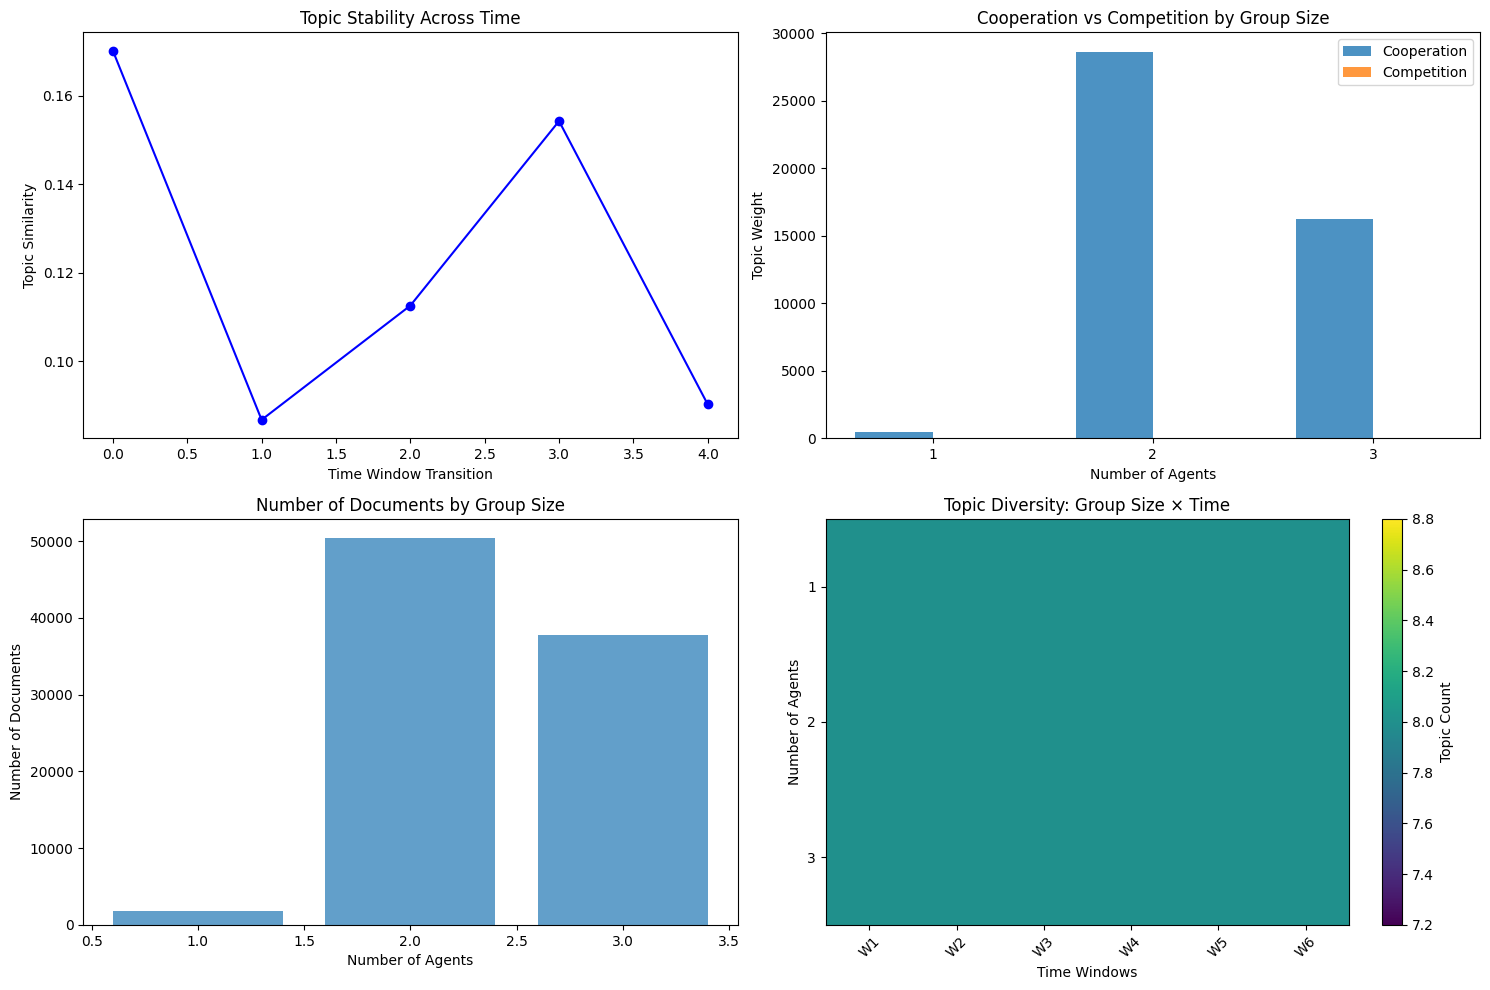


✅ Analysis complete! Results stored in analyzer.results


In [13]:
analyzer = FolkTheoremLDAAnalyzer(df, n_topics=8)
results = analyzer.run_full_analysis(window_size=50)